Run DBit-seq

In [2]:
######## load packages
import os 
import sys
sys.path.append("/home/project/11003054/changxu/Projects/SpaGNNs/code/20240112_single_change")
# sys.path.append("/home/project/11003054/changxu/Projects/SpaGNNs/code/20240109")
import pandas as pd 
import numpy as np 
import torch
import scanpy as sc
import anndata
import matplotlib.pyplot as plt
from main import fit_unsupervised
from utils import get_single_edge_index, get_multi_edge_index, lsi
from torch_geometric.nn import knn_graph, radius_graph
from augment import AUGMENTATION_SCHEMES
from adj import graph
import episcanpy as epi
from torch_geometric.utils import to_dense_adj

2024-04-30 14:37:23.244051: I external/local_tsl/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2024-04-30 14:37:25.138269: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-04-30 14:37:25.138313: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-04-30 14:37:25.309861: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-04-30 14:37:25.771885: I external/local_tsl/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2024-04-30 14:37:25.772583: I tensorflow/core/platform/cpu_feature_guard.cc:1

[easydl] tensorflow not available!


In [3]:
colormaps= ["#E41A1C", "#377EB8", "#4DAF4A", "#984EA3", "#FF7F00", "#A65628", "#FFFF33", "#F781BF", "#999999", 
"#E5D8BD", "#B3CDE3", "#CCEBC5", "#FED9A6", "#FBB4AE", "#8DD3C7", "#BEBADA", "#80B1D3", "#B3DE69", "#FCCDE5", 
"#BC80BD", "#FFED6F", "#8DA0CB", "#E78AC3", "#E5C494", "#CCCCCC", "#FB9A99", "#E31A1C", "#CAB2D6","#6A3D9A", "#B15928"]

In [4]:
def _optimize_cluster(
	adata,
	resolution: list = list(np.arange(0.1, 2.5, 0.01)),
	):
	scores = []
	for r in resolution:
		sc.tl.leiden(adata, resolution=r)
		s = calinski_harabasz_score(adata.X, adata.obs["leiden"])
		scores.append(s)
	cl_opt_df = pd.DataFrame({"resolution": resolution, "score": scores})
	best_idx = np.argmax(cl_opt_df["score"])
	res = cl_opt_df.iloc[best_idx, 0]
	print("Best resolution: ", res)
	return res



def _priori_cluster(
	adata,
	eval_cluster_n=7,
	):
	for res in sorted(list(np.arange(0.1, 2.5, 0.01)), reverse=True):
		sc.tl.leiden(adata, random_state=0, resolution=res)
		count_unique_leiden = len(pd.DataFrame(adata.obs['leiden']).leiden.unique())
		if count_unique_leiden == eval_cluster_n:
			break
	print("Best resolution: ", res)
	return res

In [5]:
def mclust_R(
	adata, 
	num_cluster, 
	modelNames='EEE', 
	used_obsm='emb_pca', 
	random_seed=2020,
	key_added = "mclust",
	):
	"""\
	Clustering using the mclust algorithm.
	The parameters are the same as those in the R package mclust.
    """
	np.random.seed(random_seed)
	import rpy2.robjects as robjects
	robjects.r.library("mclust")
	import rpy2.robjects.numpy2ri
	rpy2.robjects.numpy2ri.activate()
	r_random_seed = robjects.r['set.seed']
	r_random_seed(random_seed)
	rmclust = robjects.r['Mclust']  
	res = rmclust(rpy2.robjects.numpy2ri.numpy2rpy(adata.obsm[used_obsm]), num_cluster, modelNames)
	mclust_res = np.array(res[-2])
	adata.obs[key_added] = mclust_res
	adata.obs[key_added] = adata.obs[key_added].astype('int')
	adata.obs[key_added] = adata.obs[key_added].astype('category')

In [6]:
########## 加载数据
data_path = "/home/project/11003054/changxu/Data/DBit_seq"
data_name_list = ["0725"]
methods = "SpaGNNs"

i=0
save_path = os.path.join("/home/project/11003054/changxu/Projects/SpaGNNs/Benchmark/Integration/DBit_seq", f"{data_name_list[i]}_{methods}", "Results")
if not os.path.exists(save_path):
	os.makedirs(save_path)


adata_RNA = sc.read(os.path.join(data_path, f"{data_name_list[i]}_RNA.h5ad"))
adata_Protein = sc.read(os.path.join(data_path, f"{data_name_list[i]}_Protein.h5ad"))
adata_RNA.raw = adata_RNA
adata_Protein.raw = adata_Protein


n_clusters = len(adata_RNA.obs["ground_truth"].unique())
adata_RNA.obs["Omics"] = data_name_list[i] + "_mRNA"
adata_RNA.obs['Omics'] = adata_RNA.obs['Omics'].astype('category')
adata_Protein.obs["Omics"] = data_name_list[i] + "_Protein"
adata_Protein.obs['Omics'] = adata_Protein.obs['Omics'].astype('category')

In [7]:
sc.pp.filter_genes(adata_RNA, min_cells=3)
sc.pp.normalize_total(adata_RNA, target_sum=1e4)
sc.pp.log1p(adata_RNA)
# sc.pp.highly_variable_genes(adata_RNA, n_top_genes=2000)
# adata_RNA = adata_RNA[:, adata_RNA.var.highly_variable].copy()
# # adata_RNA.X = (adata_RNA.X - adata_RNA.X.mean(0)) / adata_RNA.X.std(0)
sc.pp.scale(adata_RNA)
sc.tl.pca(adata_RNA, n_comps=300)


# sc.pp.filter_genes(adata_RNA, min_cells=3)
# sc.pp.normalize_total(adata_RNA)
# sc.pp.log1p(adata_RNA)
# adata_RNA.X = (adata_RNA.X - adata_RNA.X.mean(0)) / adata_RNA.X.std(0)
# gene_mat = torch.Tensor(adata_RNA.X)
# u, s, v = torch.pca_lowrank(gene_mat, 100)
# gene_mat = torch.matmul(gene_mat, v)
# adata_RNA.obsm["X_pca"] = gene_mat.numpy()

sc.pp.normalize_total(adata_Protein)
sc.pp.log1p(adata_Protein)
sc.pp.scale(adata_Protein)

# muon.atac.pp.tfidf(atac, scale_factor=1e4)
# atac.layers['tf-idf'] = atac.X.copy()
# atac.X = atac.layers['counts'].copy()
# sc.pp.normalize_total(atac, target_sum=1e4)
# sc.pp.log1p(atac)
# sc.pp.highly_variable_genes(atac, n_top_genes=20000, batch_key='batch')
# atac.layers['log-norm'] = atac.X.copy()
# atac_hvf = atac[:, atac.var.highly_variable].copy()


In [8]:
# edge_index = get_single_edge_index(np.hstack((adata_RNA.obsm["X_pca"].copy(), adata_Protein.X.copy())), n_neighbors = 6)
# edge_index = get_single_edge_index(adata_RNA.obsm["spatial"].copy(), n_neighbors = 12)
# print(len(edge_index)/adata_RNA.shape[0])
# edge_index = torch.LongTensor(edge_index).T

# edge_index = radius_graph(torch.Tensor(adata_RNA.obsm["spatial"]), r = 2, loop=False)
# print(edge_index.shape[1]/adata_RNA.shape[0])
# edge_index = torch.LongTensor(edge_index).T

adj = graph(data = adata_RNA.obsm["spatial"],
					rad_cutoff = 150,
					k = 10,
					distType= "KDTree", ### "BallTree", "Radius", "kneighbors_graph",'KDTree'
					).main()["adj_norm"]

row, col, edge_attr = adj.t().coo()
edge_index = torch.stack([row, col], dim=0)

y = pd.Categorical(
            np.array(adata_RNA.obs["Omics"]),
            categories=np.unique(adata_RNA.obs["Omics"]),
        ).codes

###### 测试计算的距离的矩阵
unsuper = fit_unsupervised(save_path = save_path, use_gpu = True)
samples = unsuper._get_data(dataset_list = [adata_RNA.obsm["X_pca"].copy(), adata_Protein.X.copy()],
							batch_list = [y, y],
							domain_list = [np.zeros(adata_RNA.shape[0]), np.ones(adata_Protein.shape[0])],
							edge_index = edge_index,
							is_big = False,
							num_parts = 10,
							num_workers = 1,
							batch_size = 1,)
models = unsuper._get_model(samples, 
						n_hiddens = 128,
        				n_outputs = 64,
        				opt_GNN = "GCN",) ### MF, FeaSt, ClusterGCN, SAGE, GAT)
data_z, combine_recon, now = unsuper._train_GCAN(samples = samples,
							models = models,
							epochs = 2000,
						)

Found 2 unique domains.


Project..: 100%|█████████████████████████████████████████████████████| 2000/2000 [00:44<00:00, 45.14it/s, Loss=91.2, Diff=20.5, Domain=0.757, RE=28.8, Combine=41.1, MMD=0.0795]


Best resolution:  0.3599999999999999


R[write to console]:                    __           __ 
   ____ ___  _____/ /_  _______/ /_
  / __ `__ \/ ___/ / / / / ___/ __/
 / / / / / / /__/ / /_/ (__  ) /_  
/_/ /_/ /_/\___/_/\__,_/____/\__/   version 6.0.1
Type 'citation("mclust")' for citing this R package in publications.



fitting ...
  |======================================================================| 100%


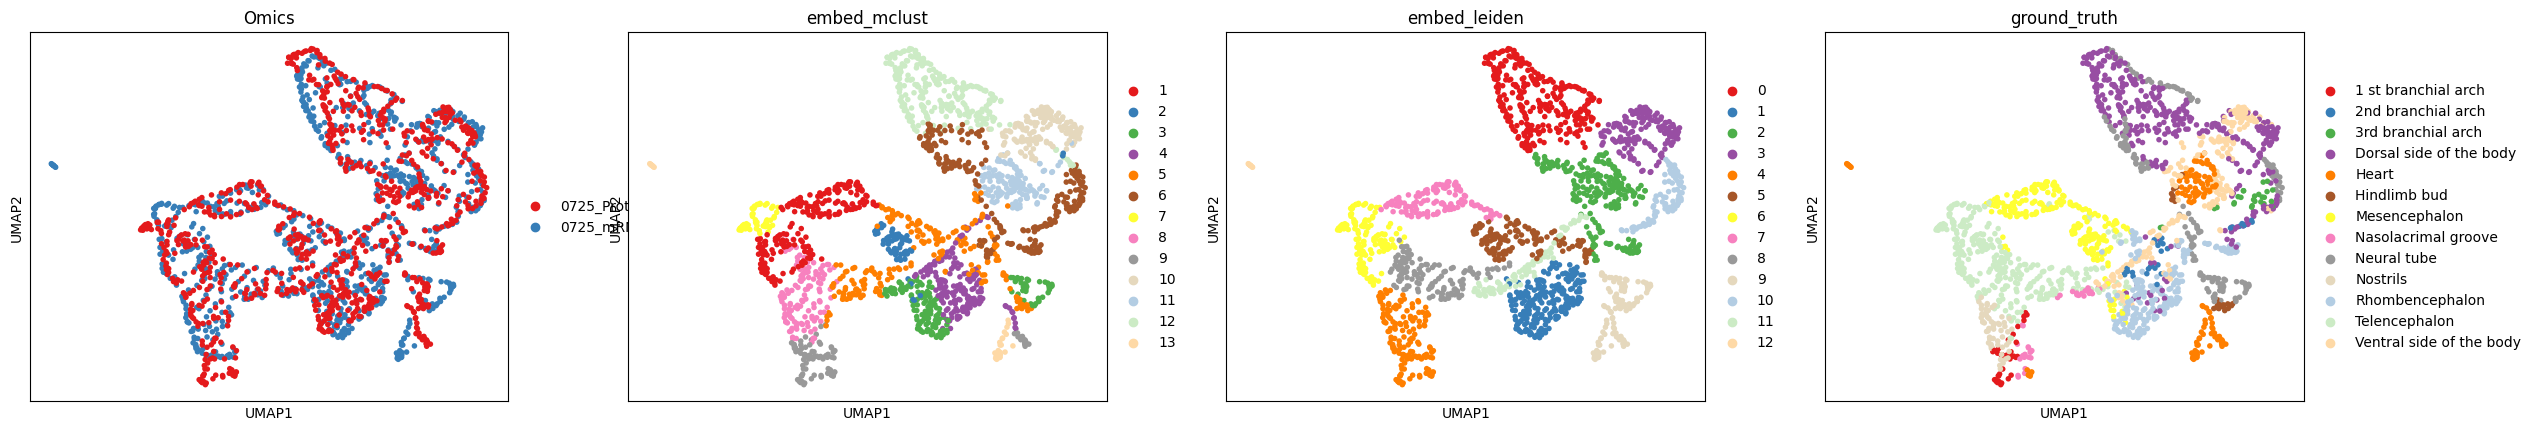

<Figure size 640x480 with 0 Axes>

In [9]:
adata_RNA.obsm[f"{methods}_embed"] = data_z[: adata_RNA.shape[0], :]
adata_Protein.obsm[f"{methods}_embed"] = data_z[adata_RNA.shape[0] :, :]
adata_RNA.obsm["combine_recon"] = combine_recon
adata_Protein.obsm["combine_recon"] = combine_recon

adata = anndata.AnnData(data_z)
adata.obs = pd.concat([adata_RNA.obs, adata_Protein.obs])
adata.obsm[f"{methods}_embed"] = data_z
sc.pp.neighbors(adata, use_rep='X')
sc.tl.umap(adata)
res_RNA_ATAC = _priori_cluster(adata, eval_cluster_n = n_clusters)
sc.tl.leiden(adata, resolution = res_RNA_ATAC, key_added="embed_leiden")
mclust_R(adata=adata, num_cluster = n_clusters, used_obsm=f"{methods}_embed", key_added="embed_mclust")
sc.pl.umap(adata, color=['Omics', "embed_mclust", "embed_leiden", "ground_truth"], palette = colormaps)
plt.savefig(os.path.join(save_path, f"{data_name_list[i]}_{methods}_embed_umap_{now}.pdf"), bbox_inches='tight', dpi = 300)

Best resolution:  0.4999999999999998
fitting ...
  |======================================================================| 100%


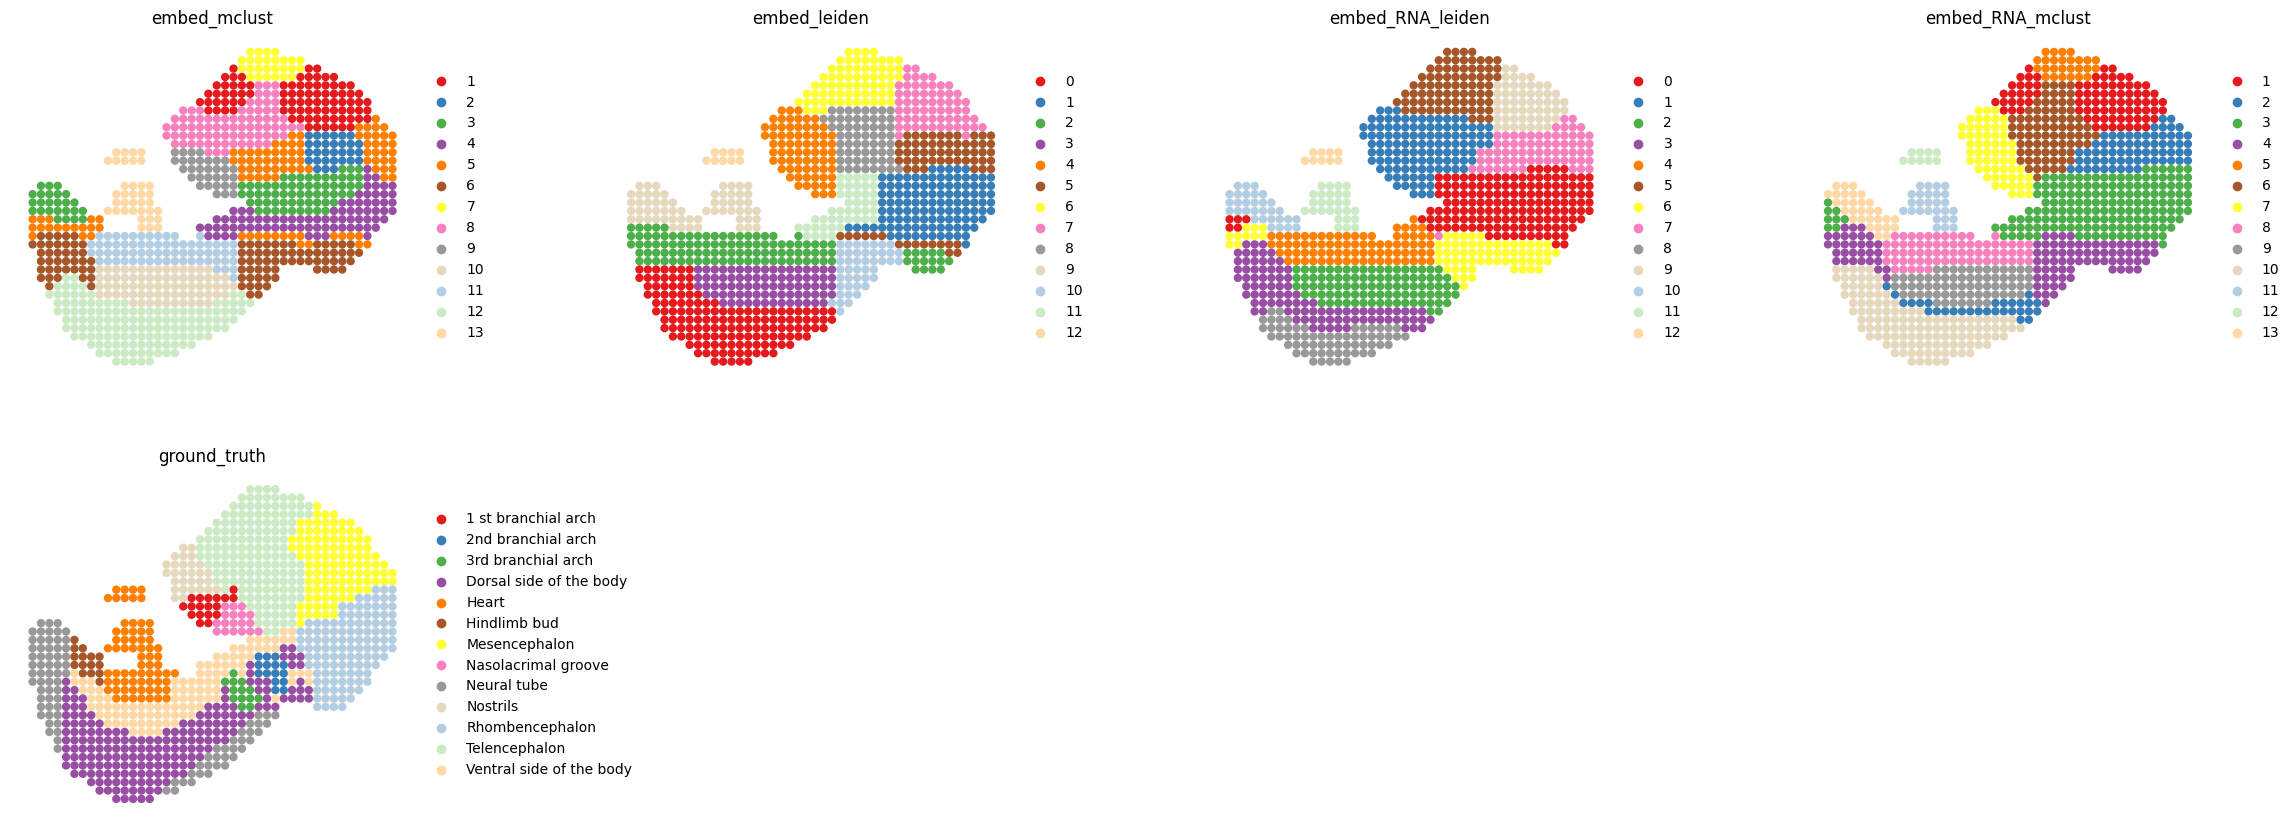

<Figure size 640x480 with 0 Axes>

In [10]:
adata_RNA.obs["embed_leiden"] = adata.obs["embed_leiden"][adata.obs["Omics"] == data_name_list[i] + "_mRNA"]
adata_Protein.obs["embed_leiden"] = adata.obs["embed_leiden"][adata.obs["Omics"] == data_name_list[i] + "_Protein"]
adata_RNA.obs["embed_mclust"] = adata.obs["embed_mclust"][adata.obs["Omics"] == data_name_list[i] + "_mRNA"]
adata_Protein.obs["embed_mclust"] = adata.obs["embed_mclust"][adata.obs["Omics"] == data_name_list[i] + "_Protein"]


####### RNA
sc.pp.neighbors(adata_RNA, use_rep=f"{methods}_embed")
res_RNA_ATAC = _priori_cluster(adata_RNA, eval_cluster_n = n_clusters)
sc.tl.leiden(adata_RNA, resolution = res_RNA_ATAC, key_added="embed_RNA_leiden")
mclust_R(adata=adata_RNA, num_cluster = n_clusters, used_obsm=f"{methods}_embed", key_added="embed_RNA_mclust")
sc.pl.spatial(adata_RNA, color=["embed_mclust", "embed_leiden", "embed_RNA_leiden", "embed_RNA_mclust", "ground_truth"], palette = colormaps,frameon=False, spot_size=1)
plt.savefig(os.path.join(save_path, f"{data_name_list[i]}_{methods}_RNA_spatial_{now}.pdf"), bbox_inches='tight', dpi = 300)

Best resolution:  0.5299999999999998
fitting ...
  |======================================================================| 100%


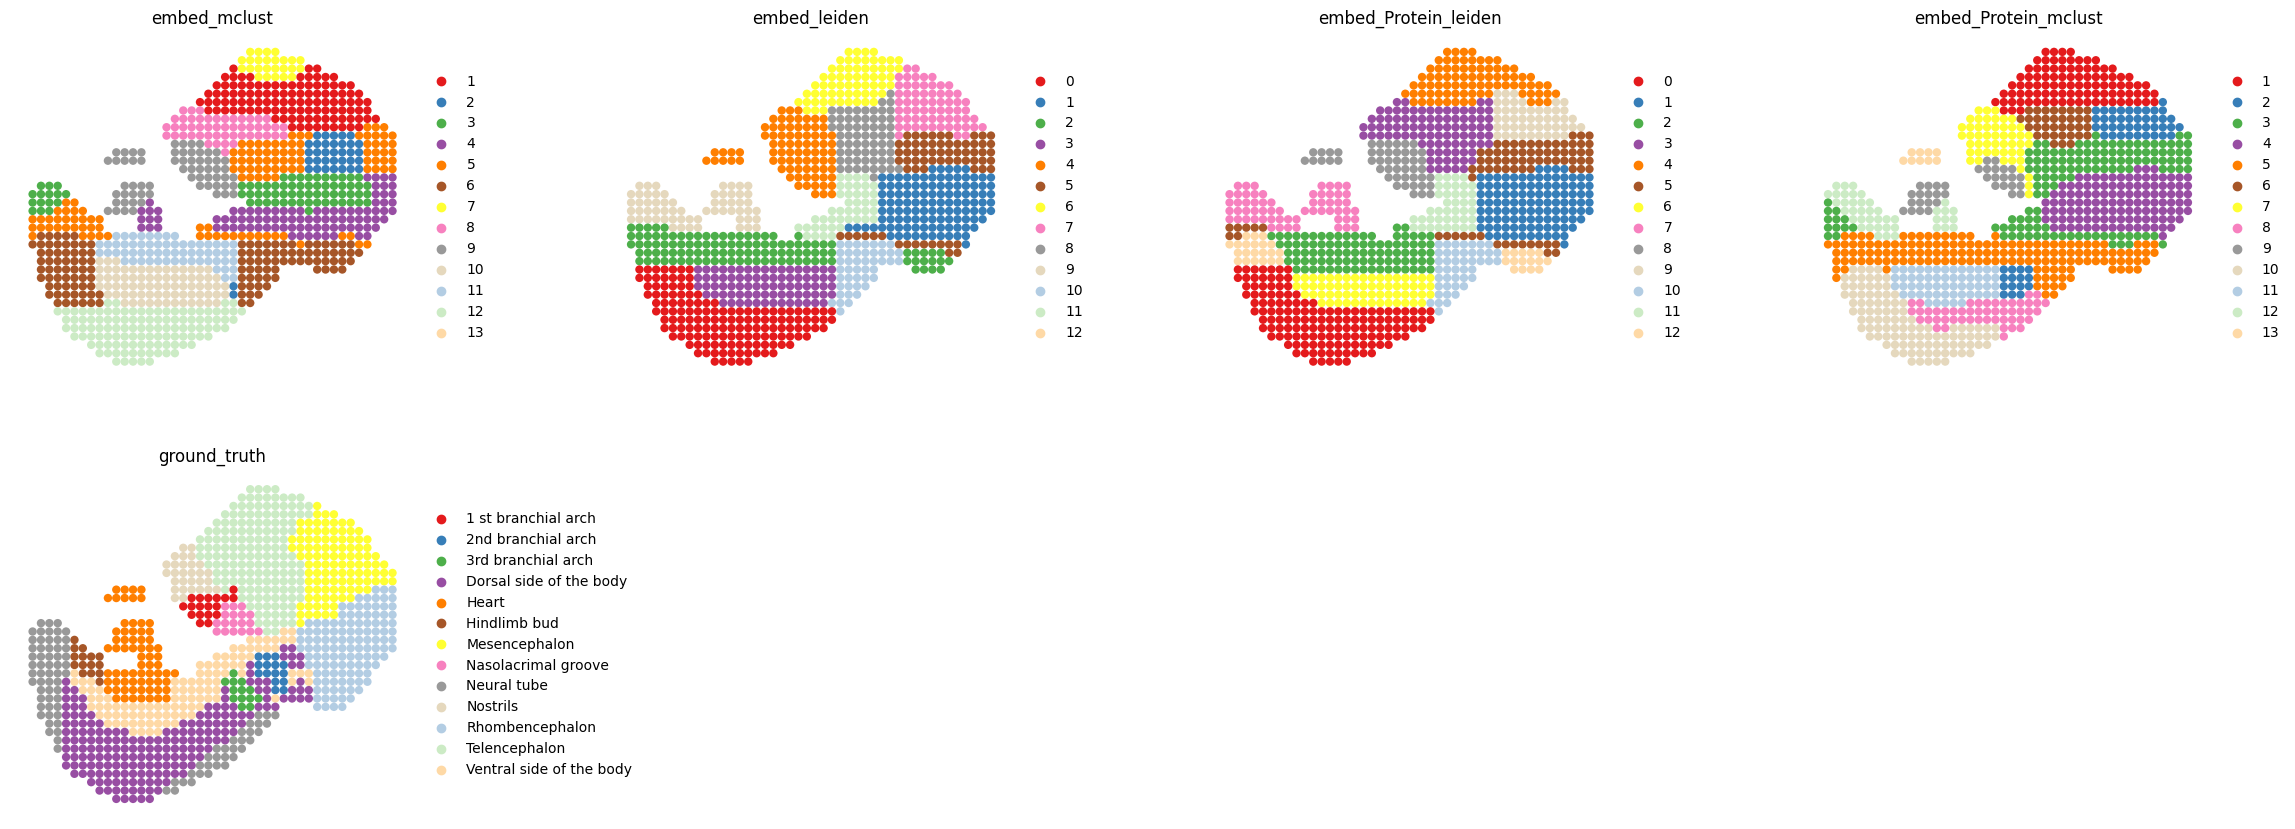

<Figure size 640x480 with 0 Axes>

In [11]:
###### Protein
sc.pp.neighbors(adata_Protein, use_rep=f"{methods}_embed")
res_RNA_ATAC = _priori_cluster(adata_Protein, eval_cluster_n = n_clusters)
sc.tl.leiden(adata_Protein, resolution = res_RNA_ATAC, key_added="embed_Protein_leiden")
mclust_R(adata=adata_Protein, num_cluster = n_clusters, used_obsm=f"{methods}_embed", key_added="embed_Protein_mclust")
sc.pl.spatial(adata_Protein, color=["embed_mclust", "embed_leiden", "embed_Protein_leiden", "embed_Protein_mclust", "ground_truth"], palette = colormaps,frameon=False, spot_size=1)
plt.savefig(os.path.join(save_path, f"{data_name_list[i]}_{methods}_Protein_spatial_{now}.pdf"), bbox_inches='tight', dpi = 300)

Best resolution:  0.5199999999999998
fitting ...
  |======================================================================| 100%


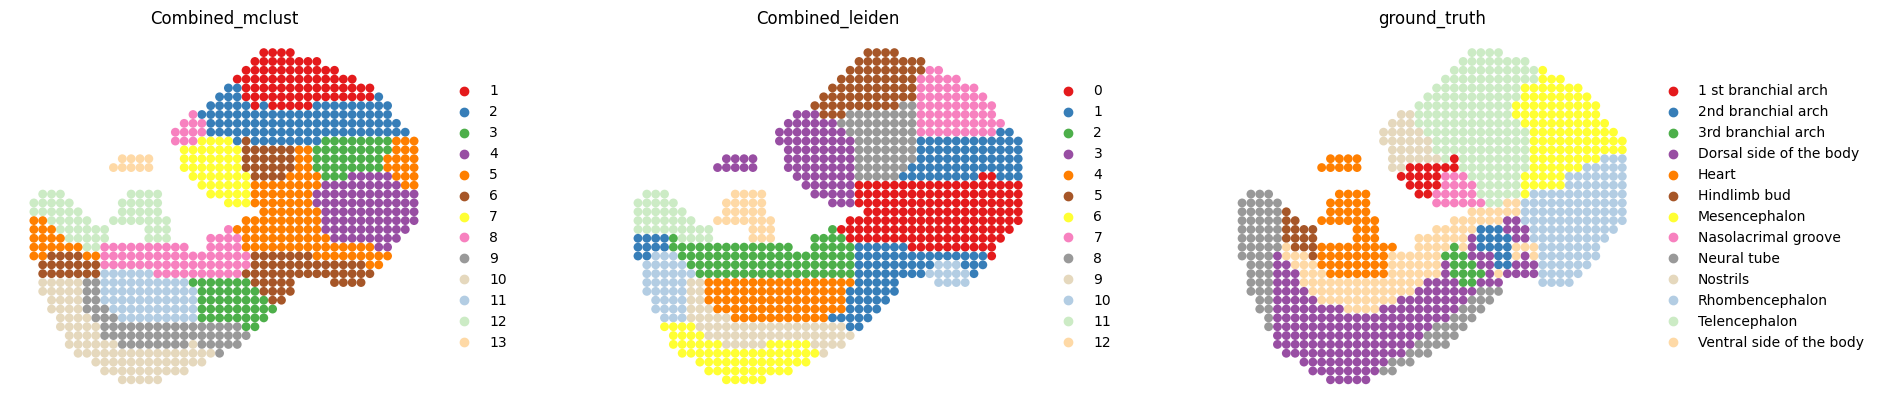

<Figure size 640x480 with 0 Axes>

In [12]:
####### Combined
sc.pp.neighbors(adata_RNA, use_rep='combine_recon')
res_RNA_ATAC = _priori_cluster(adata_RNA, eval_cluster_n = n_clusters)
sc.tl.leiden(adata_RNA, resolution = res_RNA_ATAC, key_added="Combined_leiden")
mclust_R(adata=adata_RNA, num_cluster = n_clusters, used_obsm="combine_recon",key_added="Combined_mclust")
sc.pl.spatial(adata_RNA, color=["Combined_mclust", "Combined_leiden", "ground_truth"], palette = colormaps, frameon=False, spot_size=1)
plt.savefig(os.path.join(save_path, f"{data_name_list[i]}_{methods}_Combined_spatial_{now}.pdf"), bbox_inches='tight', dpi = 300)

In [13]:
adata.write(os.path.join(save_path,f"{data_name_list[i]}_{methods}_RNA_Protein_{now}.h5ad"),compression="gzip")
adata_RNA.write(os.path.join(save_path,f"{data_name_list[i]}_{methods}_RNA_{now}.h5ad"),compression="gzip")
adata_Protein.write(os.path.join(save_path,f"{data_name_list[i]}_{methods}_Protein_{now}.h5ad"),compression="gzip")